In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 1
%pwd

'/ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks'

In [3]:
import sys, os
import numpy as np
import xarray
import matplotlib.pyplot as plt

os.environ['DDEBACKEND'] = 'pytorch'
sys.path.append('..')
%aimport mre_pinn

Loading /ocean/projects/asc170022p/mtragoza/MRE-PINN/notebooks/../mre_pinn/__init__.py
Using backend: pytorch



## BIOQIC FEM box simulation data

In [4]:
# load the MATLAB file
data_root = '../data/BIOQIC'
mat_base = 'four_target_phantom.mat'


mat_file = data_root + '/' + mat_base
data, rev_axes = mre_pinn.data.load_mat_data(mat_file, verbose=True)

Loading ../data/BIOQIC/four_target_phantom.mat
    __header__: <class 'bytes'>
    __version__: <class 'str'>
    __globals__: <class 'list'>
    u_ft: <class 'numpy.ndarray'> (100, 80, 10, 3, 6) complex128


In [6]:
u = data['u_ft'].T
labels = ['frequency', 'component', 'z', 'x', 'y']
u.shape

(6, 3, 10, 80, 100)

(6, 3, 10, 80, 100)
(6, 3, 10, 80, 100)


<IPython.core.display.Javascript object>


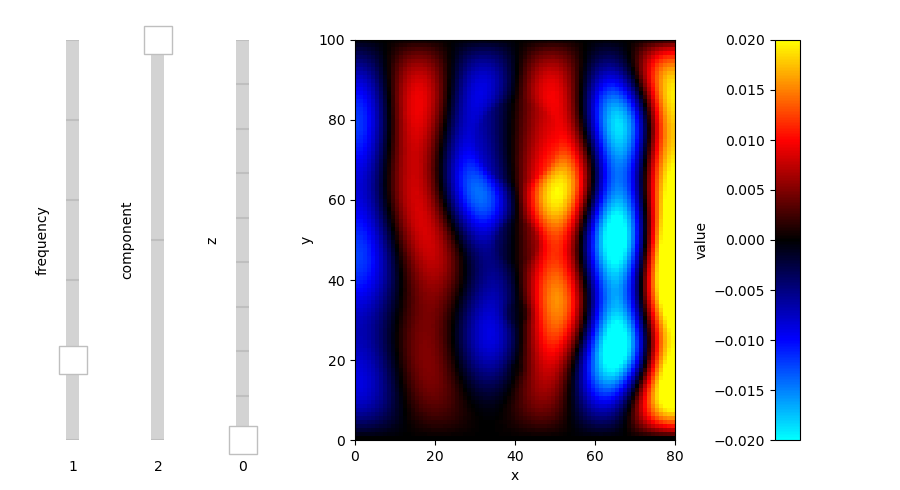

In [8]:
%autoreload
import matplotlib

w_map = mre_pinn.visual.wave_color_map()
w_max = 0.02
wave_kws = dict(cmap=w_map, vmin=-w_max, vmax=w_max)

class NDArrayViewer(object):
    
    def __init__(self, array, labels, ax_height=2, ax_width=2, bar_width=0.25, **kwargs):
        
        print(array.shape)
        assert array.ndim >= 2
        assert len(labels) == array.ndim
        n_rows = 1
        n_cols = array.ndim
        
        # configure plot grid spacing
        hspace = 0.3
        wspace = 0.6
        lpad = 0.6
        rpad = 1.0
        bpad = 0.5
        tpad = 0.4
        #hspace = wspace = lpad = rpad = bpad = tpad = 0

        fig_height = n_rows * ax_height + (n_rows - 1) * hspace + bpad + tpad
        fig_width = ax_width + (n_cols - 1) * bar_width + (n_cols - 1) * wspace + lpad + rpad
        width_ratios = [bar_width] * (array.ndim - 2) + [ax_width, bar_width]

        self.fig, self.axes = plt.subplots(
            n_rows, n_cols, squeeze=False,
            figsize=(fig_width, fig_height),
            gridspec_kw=dict(
                width_ratios=width_ratios,
                hspace=hspace, wspace=wspace,
                left=lpad/fig_width, right=1 - rpad/fig_width,
                bottom=bpad/fig_height, top=1 - tpad/fig_height
            )
        )

        self.a = array
        self.idx = (0,) * (array.ndim - 2)

        # plot image and colorbar
        self.im = mre_pinn.visual.plot_image_2d(
            self.a[self.idx], resolution=1, ax=self.axes[0,-2], xlabel='x', ylabel='y', **kwargs
        )
        self.cbar = mre_pinn.visual.plot_colorbar(self.im, ax=self.axes[0,-1], label='value')
        
        def updater(i):
            def update(new_val):
                idx = list(self.idx)
                idx[i] = new_val
                self.idx = tuple(idx)
                self.im.set_array(self.a[self.idx].T)
                self.fig.canvas.draw()
            return update

        # add index sliders
        self.sliders = []
        for i in range(array.ndim - 2):
                            
            slider = self.add_index_slider(self.axes[0,i], updater(i), self.a.shape[i], label=labels[i])
            self.sliders.append(slider)
            
    def add_index_slider(self, ax, func, n, label=None):
        slider = matplotlib.widgets.Slider(
            ax, None, 0, n-1, valstep=1, orientation='vertical',
            handle_style=dict(size=20)
        )
        slider.on_changed(func)
        #slider.track.set_xy((0, 0))
        #slider.track.set_width(1.0)
        slider.poly.set_visible(False)
        slider.hline.set_visible(False)
        slider.label.set_y(1.05)
        slider.valtext.set_y(-0.05)
        slider._handle.set_marker('s')
        slider._handle.set_zorder(10)
        ax.hlines(np.arange(n), 0.25, 0.75, color='0.75', zorder=9)
        ax.set_xlim(0, 1)
        ax.set_axis_on()
        ax.set_xticks([])
        ax.set_yticks([])
        for s in ax.spines:
            ax.spines[s].set_visible(False)
        ax.set_ylabel(label)
        return slider

print(u.shape)
NDArrayViewer(u.imag, labels, ax_height=4, ax_width=4, **wave_kws)